# Vehicle Detection

In this project we detect vehicles from the self driving car dashcam and draw bounding box around the vehicles. Vehicle detection is an import part for autonomous driving to avoid collisions and maintain proper distance on the road. 

The steps involved for detection are:

1. Feature extraction for window classifier - including HOG features, spatial binning, color historams
2. Build classifier on the Vehicles and Non-Vehicles training data based on extracted features
3. Sliding window search on each frame of the video for drawing the bounding box around vehicles
4. Process the video frame by frame with the image processing pipeline, draw bounding box and re-assemble new video

Heatmaps are used for overlapping bounding boxes

In [45]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import cv2
import glob

from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from scipy.ndimage.measurements import label
from sklearn.externals import joblib

%matplotlib inline

### Preprocessed images and converted to jpg

Note: The Vehicles and Non-Vehicles dataset provided had images in .png format. These were converted to /jpg using handy linux convert utility.

    ls -1 *.png | xargs -n 1 bash -c 'convert "$0" "${0%.png}.jpg"'
    

In [31]:
cars = glob.glob('./vehicles/*/*.jpg')
print(len(cars))

8792


In [32]:
non_cars = glob.glob('./non-vehicles/*/*.jpg')
print(len(non_cars))

8968


In [33]:
def plot_image_set(images, titles, image_type=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(images[0], cmap=image_type)
    ax1.set_title(titles[0], fontsize=30)
    ax2.imshow(images[1], cmap=image_type)
    ax2.set_title(titles[1], fontsize=30)

## Feature Extraction Parameters

After several round of trial and error, the following are the parameters chosen for HOG, Spatial Bins and Color Histograms:-

  - Color Channel - RGB
  - Orientation bins - 8
  - Pixels per cell - 8
  - Cells per block - 2
  - Histogram Bins - 48
  - Histogram Bins Range - (0, 256)
  - Spatial Image Size - (16, 16)

In [34]:
params = dict()
params['nbins'] = 48
params['bins_range'] = (0, 256)
params['resize_image_size'] = (16, 16)
params['orient'] = 8
params['pixels_per_cell'] = 8
params['cells_per_block'] = 2

### Color histogram for each of the color channels

In [35]:
def color_hist(image, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

### Spatial binning of the images

In [36]:
def bin_spatial(image, size=(32, 32)):
    features = cv2.resize(image, size).ravel()
    return features

### Hog Feature extraction

Hog features are extracted individually from each of the color channels. Features extracted from each color channels are appended and np.ravel() is used to return 1-D array of features of all the color channels.

In [37]:
def get_hog_features(image, orient, pix_per_cell, cell_per_block):
    hog_features = []
    for color_channel in range(image.shape[2]):
        channel_features = hog(image[:,:,color_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                           visualise=False, feature_vector=True)
        hog_features.append(channel_features)
    hog_features = np.ravel(hog_features)    
    return hog_features

### Extract all the features

In [38]:
def extract_features(images, params):
    features = []
    for img_path in images:
        image = mpimg.imread(img_path)
        spatial_features = bin_spatial(image, size=params['resize_image_size'])
        hist_features = color_hist(image, nbins=params['nbins'], bins_range=params['bins_range'])
        hog_features = get_hog_features(image, params['orient'], params['pixels_per_cell'], params['cells_per_block'])
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    return features

Utility function to extract features from a single image

In [39]:
def extra_single_features(image, params):
    spatial_features = bin_spatial(image, size=params['resize_image_size'])
    hist_features = color_hist(image, nbins=params['nbins'], bins_range=params['bins_range'])
    hog_features = get_hog_features(image, params['orient'], params['pixels_per_cell'], params['cells_per_block'])
    return np.concatenate((spatial_features, hist_features,hog_features))

Now we process Vehicles and Non-vehicles training data provided and extract all the features for classifying

In [40]:
car_features = extract_features(cars, params)

In [41]:
non_car_features = extract_features(non_cars, params)

### Train/Test split

Do the train/test split for both the vehicle and non-vehicle data sets

In [42]:
def create_train_test_set(car_features, non_car_features):
    X = np.vstack((np.array(car_features), np.array(non_car_features))).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    Y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
    X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=1234)
    
    return X_train, Y_train, X_test, Y_test, X_scaler

In [43]:
X_train, Y_train, X_test, Y_test, X_scaler = create_train_test_set(car_features, non_car_features)

## SVC Classifier

VC function of sklearn.svm was used for building the classifier. SVC was chosen instead of LinearSVC because it resulted in increased accuracy, due to the probabilistic output of SVC.

An overall accuracy of 99.6% was achieved 

In [44]:
def train_test_svm(X_train, Y_train, X_test, Y_test):
    svc = SVC(C=1.0, probability=True)
    svc.fit(X_train, Y_train)
    
    print("Accuracy of classifier - {:.4f}".format(svc.score(X_test, Y_test)))
    return svc

In [46]:
clf = train_test_svm(X_train, Y_train, X_test, Y_test)

Accuracy of classifier - 0.9961


### Save classifier

Classifier was picked for iterative tests

In [47]:
joblib.dump(clf, 'model.pkl') 

['model.pkl']

### Sliding Window Search

After lot of trial and error following parameters were selected for the bounding box and sliding window search 

Three different window sizes were selected.

    For small windows :-
          a) Window Size - (64, 64)
          b) X Start Stop - (640, 1280)
          c) Y Start Stop - (300, 450)
          d) Overlap - (0.6, 0.6)

    For medium windows :-
          a) Window Size - (96, 96)
          b) X Start Stop - (640, 1280)
          c) Y Start Stop - (300, 500)
          d) Overlap - (0.8, 0.8)
          
    For large windows :-
          a) Window Size - (128, 128)
          b) X Start Stop - (640, 1280)
          c) Y Start Stop - (400, 550)
          d) Overlap - (0.85, 0.85)
          

All the windows obtained from above setsp are passed to seach_window to get the actual hot boxes using the SVC classifier predictions. The classifier is used to predict the probability of a car being present in the image. If probability is greater than 0.5 then, car is present in the image.

Next, a heatmap is created using the hot boxes from above step. And Apply_threshold is called to remove some of the false positives present.

scipy.ndimage.measurements' label() function helps in labelling the thresholding regions. Finally draw_labeled_bboxes is used to draw bounding box around the detected car.

In [48]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy
    
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    window_list = []
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    
    return window_list

In [49]:
def search_windows(img, windows, clf, scaler, params):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = extra_single_features(test_img, params)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction > 0.5:
            on_windows.append(window)
    return on_windows

In [50]:
all_test_images = glob.glob('test_images/*')

In [51]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [52]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_w, bbox_h = abs(bbox[1][0] - bbox[0][0]), abs(bbox[1][1] - bbox[0][1])
        if bbox[0][1] <= 300:
            continue
        if bbox[0][1] >= 600:
            continue
        if bbox[0][0] >= 1220:
            continue
        bbox_area = bbox_w * bbox_h
        if bbox_area <= 2500:
            continue
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

### Full image processing pipeline

Bounding boxes obtained in image pipeline in each frame were flickering a lot. To reduce the flickering Exponential Smoothening has been used. Heatmaps obtained from previous frame is given weightage of 0.2 and heatmaps from current frame are given weightage of 0.8 (values arrived after many experiments).

In [53]:
def image_pipeline(image, static_images=False):
    global prev_frame_heat
    image_copy = np.copy(image)
    
    windows1 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[300, 450], 
                xy_window=(64, 64), xy_overlap=(0.6, 0.6))
    
    windows2 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[300, 500], 
                xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    
    windows3 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[400, 550], 
                xy_window=(128, 128), xy_overlap=(0.85, 0.85))

    windows = windows1 + windows2 + windows3 

    hot_windows = search_windows(image, windows, clf, X_scaler, params)                  

    heat_image = np.zeros_like(image[:,:,0]).astype(np.float)

    add_heat(heat_image, hot_windows)
    
    '''Apply Simple Exponential Filter'''
    if not static_images:
        if prev_frame_heat == None:
            prev_frame_heat = heat_image
        else:
            heat_image = (prev_frame_heat * 0.2) + (heat_image * 0.8)
            prev_frame_heat = heat_image
        
    heatmaps = apply_threshold(heat_image, 2)
    labels = label(heatmaps)  #from scipy.ndimage.measurements
    
    final_image = draw_labeled_bboxes(np.copy(image), labels)
    return final_image

### False positive handling

To remove False positives following techniques were used: 

- draw_labeled_bboxes() function checks whether the minimum y-coordinate values is in between 300 and 600. If not, then don't draw the box. Also, minimum x-coordinate value should be less than 1220. One more check of the area of the box has been used to remove small False positve boxes. If the area of the box is less than 2500, then don't draw it.

- Use of SVC with probabilitic prediction instead of normal LinearSVC also helped in removing many False positives.

- Heatmaps and thresholding on those heatmaps also helped in removing False positives.

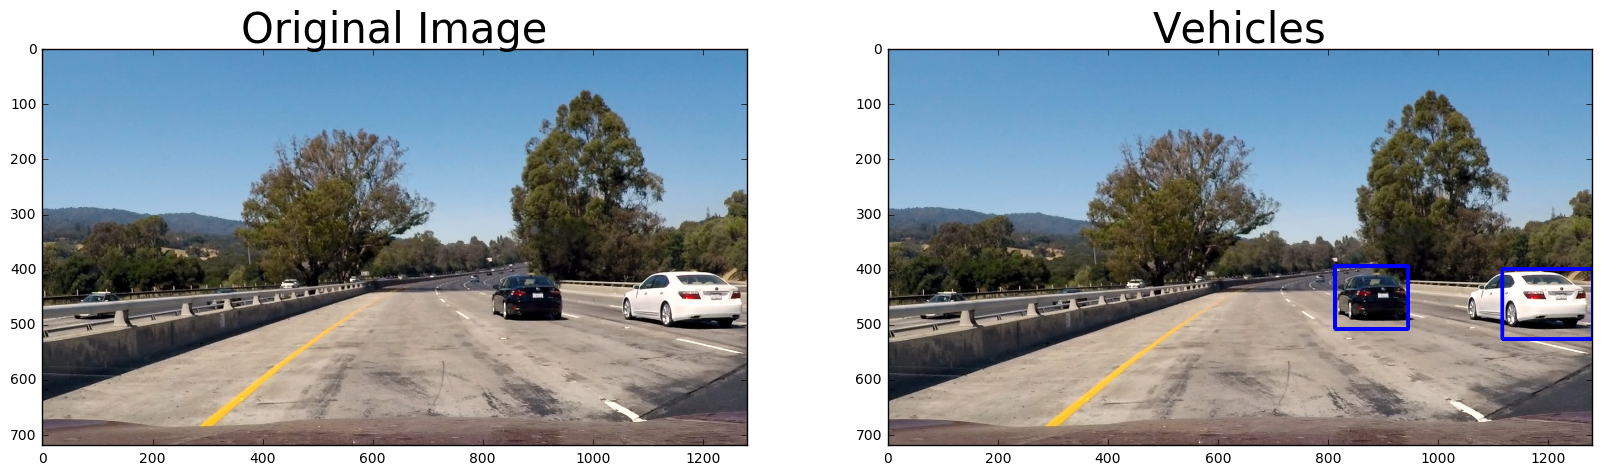

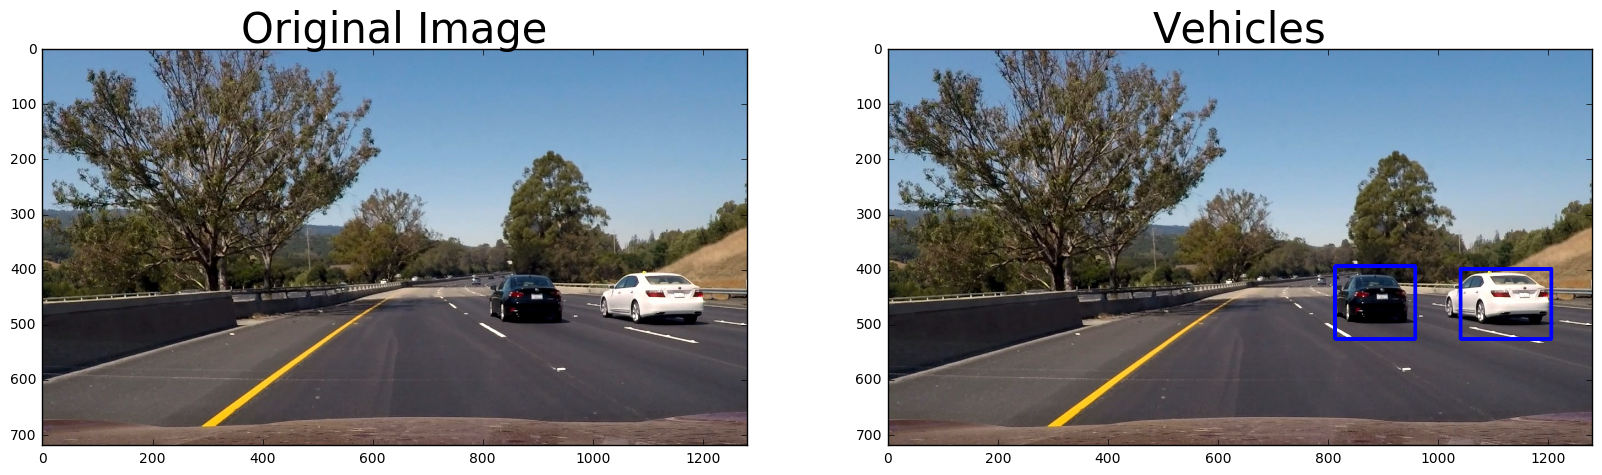

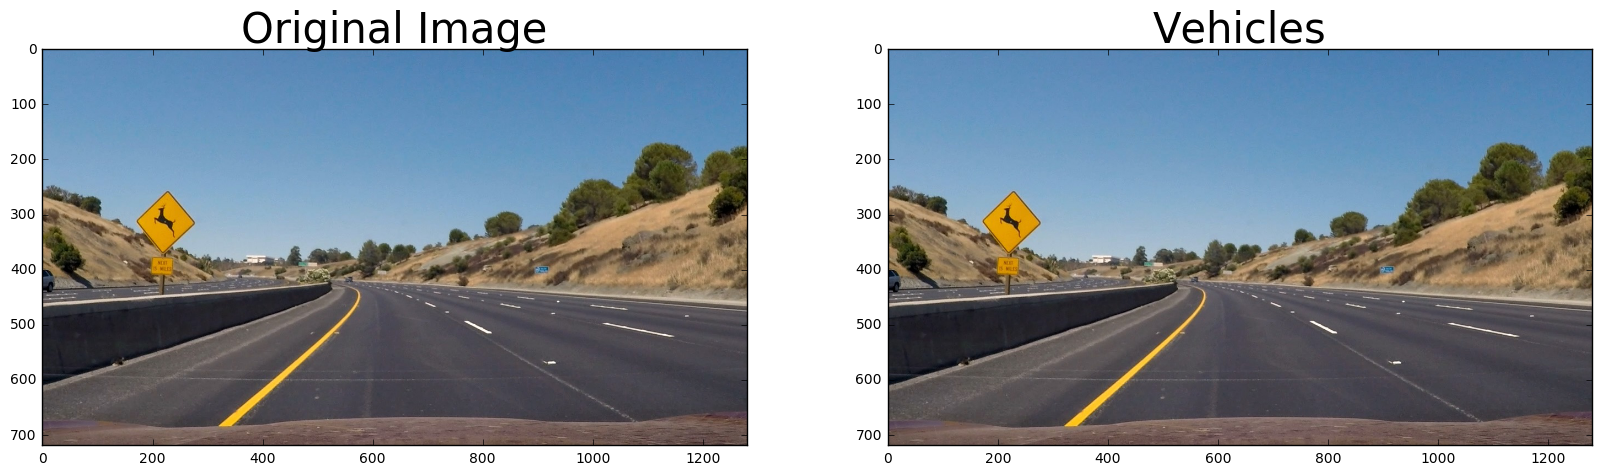

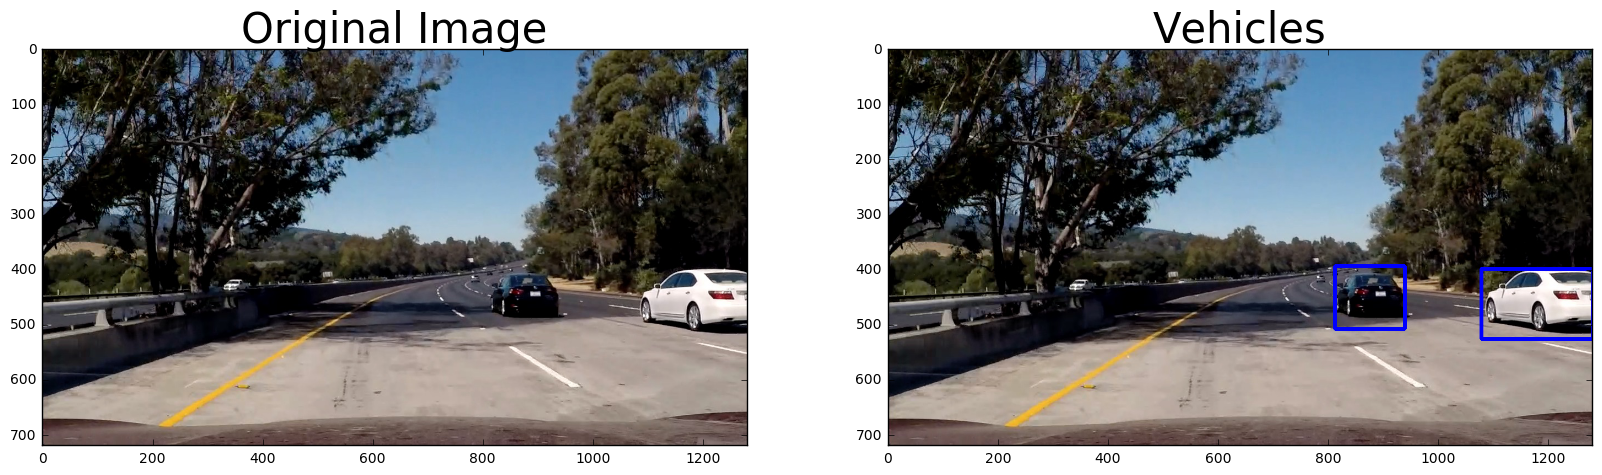

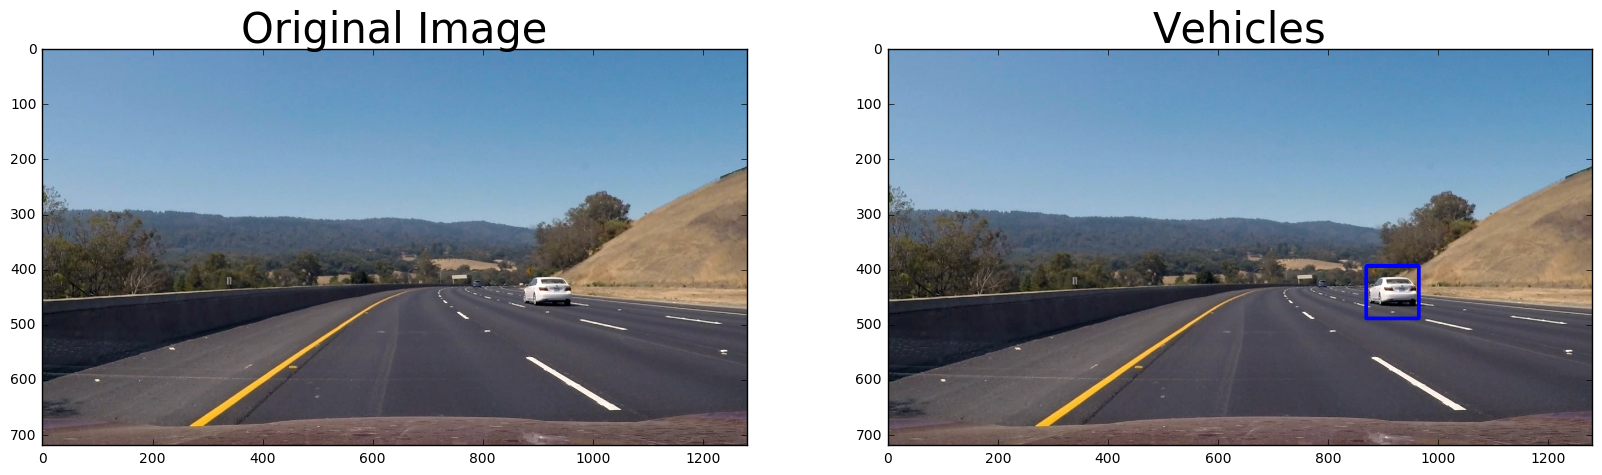

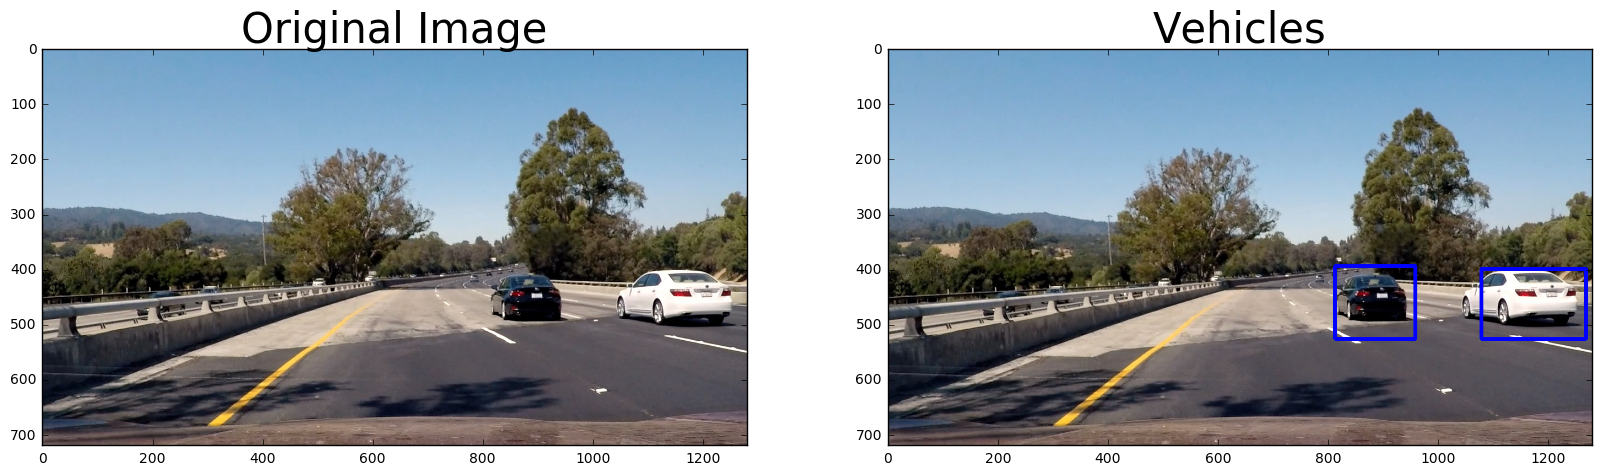

In [54]:
for image_path in all_test_images:
    test_img = mpimg.imread(image_path)
    res_img = image_pipeline(test_img, static_images=True)
    plot_image_set([test_img, res_img], titles=['Original Image', 'Vehicles'])

### Inside look

Let's look inside the vehicle object detection and see the intermediate steps with multi-boxes and heatmaps

In [60]:
def image_pipeline_details(image, static_images=False):
    global prev_frame_heat
    image_copy = np.copy(image)
    
    windows1 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[300, 450], 
                xy_window=(64, 64), xy_overlap=(0.6, 0.6))
    
    windows2 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[300, 500], 
                xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    
    windows3 = slide_window(image, x_start_stop=[640, 1280], y_start_stop=[400, 550], 
                xy_window=(128, 128), xy_overlap=(0.85, 0.85))

    windows = windows1 + windows2 + windows3 

    hot_windows = search_windows(image, windows, clf, X_scaler, params)                  

    heat_image = np.zeros_like(image[:,:,0]).astype(np.float)

    add_heat(heat_image, hot_windows)
    
    '''Apply Simple Exponential Filter'''
    if not static_images:
        if prev_frame_heat == None:
            prev_frame_heat = heat_image
        else:
            heat_image = (prev_frame_heat * 0.2) + (heat_image * 0.8)
            prev_frame_heat = heat_image
        
    heatmaps = apply_threshold(heat_image, 2)
    labels = label(heatmaps)
    
    final_image = draw_labeled_bboxes(np.copy(image), labels)
    hot_image = draw_boxes(np.copy(image), hot_windows)
    
    return final_image, heat_image, hot_image

In [61]:
def plot_image_set4(images, titles, image_type=None):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
    ax1.axis('off')
    ax1.imshow(images[0], cmap=image_type)
    ax1.set_title(titles[0], fontsize=20)
    ax2.axis('off')
    ax2.imshow(images[1], cmap=image_type)
    ax2.set_title(titles[1], fontsize=20)
    ax3.axis('off')
    ax3.imshow(images[2], cmap=image_type)
    ax3.set_title(titles[2], fontsize=20)
    ax4.axis('off')
    ax4.imshow(images[3], cmap=image_type)
    ax4.set_title(titles[3], fontsize=20)

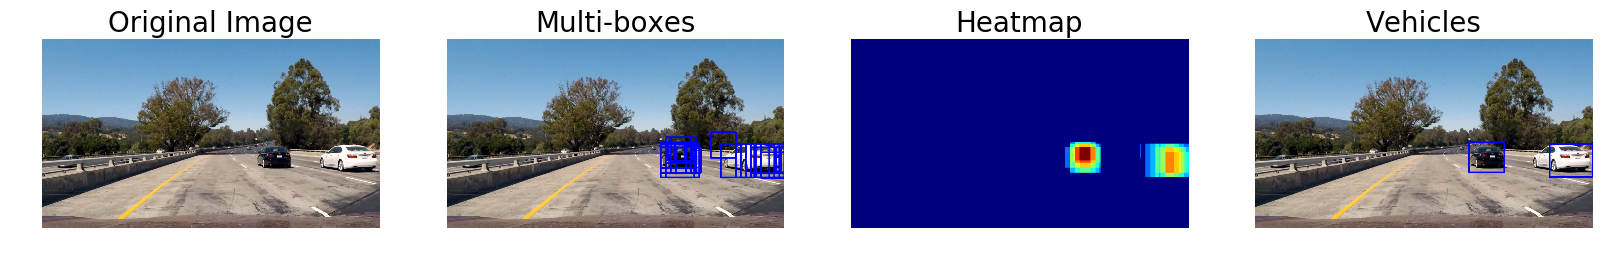

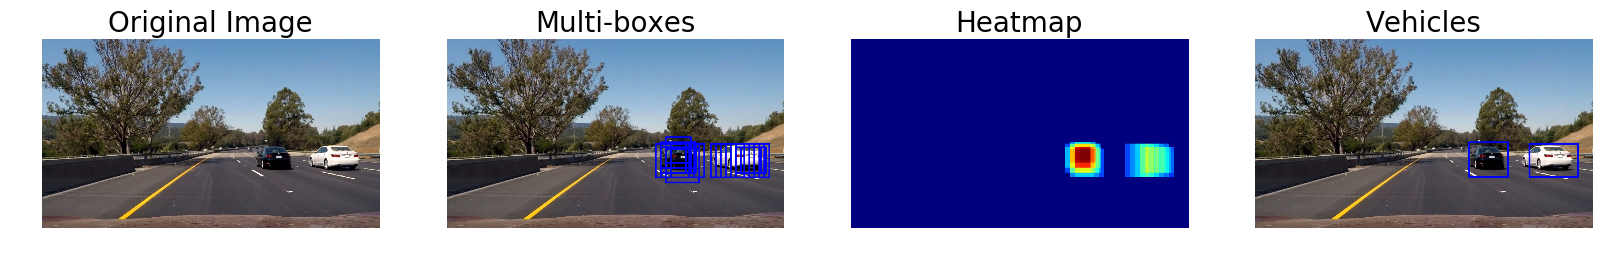

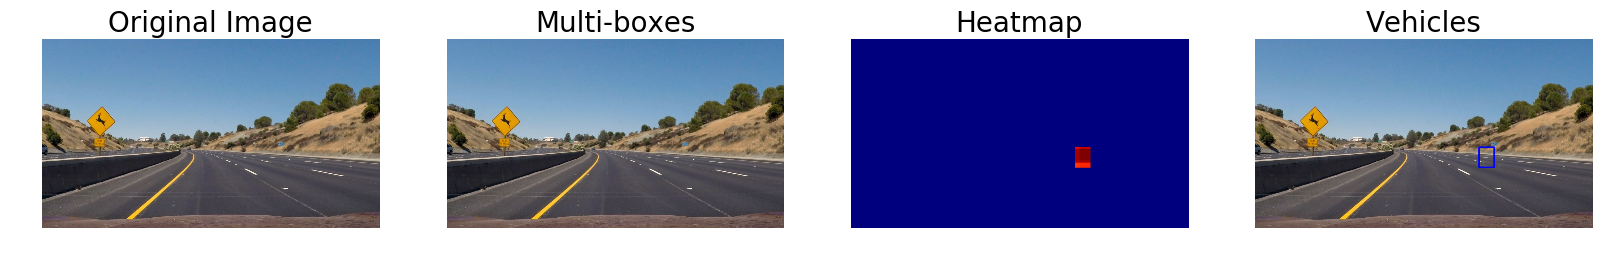

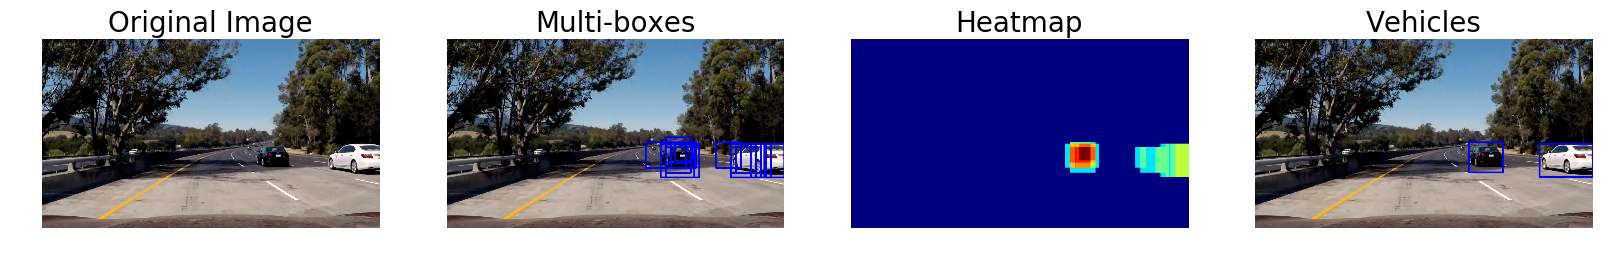

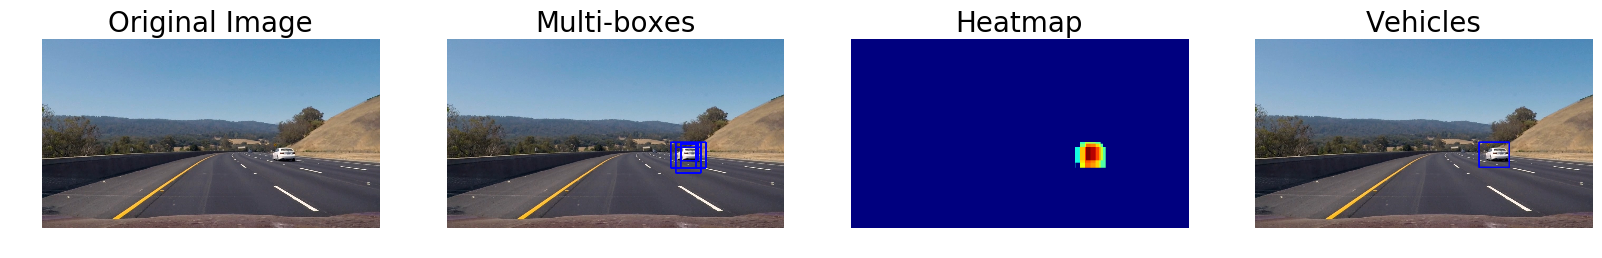

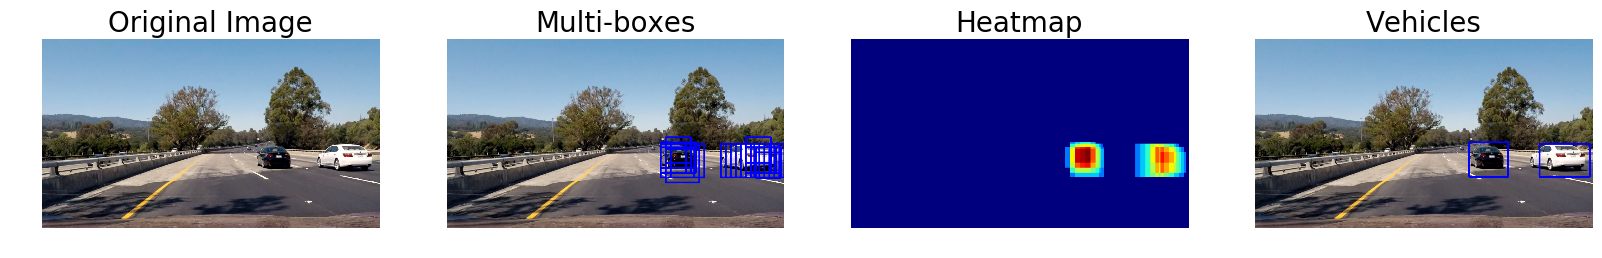

In [62]:
prev_frame_heat = None
for image_path in all_test_images:
    test_img = mpimg.imread(image_path)
    res_img, heat_img, hot_img = image_pipeline_details(test_img, static_images=False)
    plot_image_set4([test_img, hot_img, heat_img, res_img], titles=['Original Image',"Multi-boxes", 'Heatmap', "Vehicles"])

### Video processing

We will now process the video through the vehicle detection image pipeline and generate a new video with bounding boxes around the vehicles.

In [55]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [56]:
def process_image(image):
    result = image_pipeline(image)
    return result

In [57]:
prev_frame_heat = None
output_clip = 'project_video_result.mp4'
input_clip = VideoFileClip("project_video.mp4")
clip = input_clip.fl_image(process_image)
%time clip.write_videofile(output_clip, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4



100%|█████████▉| 1260/1261 [4:43:34<00:13, 13.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 4h 43min 36s, sys: 1.45 s, total: 4h 43min 37s
Wall time: 4h 43min 34s


In [58]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))

### Challenges faced and future exploration

Removing False positives was the biggest challenge. There are still some False positives in the final video and pipeline needs to be further improved. Weighted moving average could be used to further reduce the flickering in the video. 

As next steps I would like to explore Facebook Research's [MultiPathNet Object Detection](https://arxiv.org/abs/1604.02135) Deep Learning model for vehicle detection.

The pipeline is also very time consuming, taking many hours to generate the final video even when running on aws p2.8xlarge machines. Techiques for optimizing and parallelizing the pipeline are needed especially for the vehicle detection part, otherwise things will not work in real-time for a real autonomous car. Reducing the search area for the search window and Facebook's MultiPathNet could be possible options for optimizing. 
